**Names:** Brett Nesfeder, MacAlistair Husted, Priyanka Choudhary, Shruti Kapur, Jocelyne Walker

**Forum:** Midsize Sedans 2.0, pages 403-503

https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0/p403


**1. Scraper that outputs .csv**

**2. Fetch around 5000 posts** 

In [ ]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
import pandas as pd
from google.colab import  drive

from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver =webdriver.Chrome('chromedriver',options=options)

comment_ids = []
comments = pd.DataFrame(columns = ['Date','user_id','comments']) 

# for the page numbers 403-503 on the forum (newer posts)
for i in range(403,504):
  link = 'https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0/p' + str(i)
  print(link)
  driver.get(link)

  ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
  comment_ids = []

  #pull all the comment ids on each page
  for i in ids:
    comment_ids.append(i.get_attribute('id'))

  for x in comment_ids:
      #Extract dates from for each user on a page
      user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
      date = user_date.get_attribute('title')

      #Extract user ids from each user on a page
      userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
      userid = userid_element.text

      #Extract Message for each user on a page
      #First, try to pull all the text paragraphs (prevents blockquotes from being pulled)
      user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]/p')
      comment = ''
      for value in user_message:
        comment += value.text
        comment += '\n'
      
      #If there are no text paragraphs, then instead pull the entire block's text (only used in the case of entries that do not have multiple paragraphs)
      if comment == '':
         user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
         comment = user_message.text                             
      
      #Adding date, userid and comment for each user in a dataframe    
      comments.loc[len(comments)] = [date,userid,comment]
    
drive.mount('/drive')
comments.to_csv('/drive/My Drive/comments.csv',index=False)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (121 kB/s)
Reading package lists... Done
Reading package lists... Done
Building d

**3a. Replace frequently occurring car models with brands**

**3b. Find the top 10 brands from frequncy counts**

AND 

**Task A: MDS Map**

In [2]:
import pandas as pd 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from collections import defaultdict
import re
from nltk.corpus import stopwords
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from google.colab import files
import io
from google.colab import  drive

uploaded = files.upload()
file = pd.read_csv(io.BytesIO(uploaded['comments.csv']))
file['comments'] = file['comments'].astype(str)
file["comments"] = file["comments"].str.lower()

#Convert the model names to brand names
brandconverter = pd.read_csv(io.BytesIO(uploaded['car models and brands.csv']), header = None)
brandconverter.columns = ['brand','model']
s = brandconverter.set_index('model')['brand']
s.index = r'\b' + s.index + r'\b' # Takes care of word boundary condition
file['comments'] = file['comments'].replace(s, regex=True)

stops =set(stopwords.words("english"))
def identify_tokens(row):
    tokens = nltk.word_tokenize(row)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words 

file['words'] = file['comments'].apply(identify_tokens)

def remove_stops(row):
    row
    non_stop = [w for w in row if not w in stops]
    return (non_stop)

#Remove stopwords
file['words'] = file['words'].apply(remove_stops)

def rejoin_words(row):
    row
    joined_words = ( " ".join(row))
    return joined_words

file['processed'] = file['words'].apply(rejoin_words)
cv=CountVectorizer()
word_count_vector = cv.fit_transform(file['processed'])
word_count = pd.DataFrame(word_count_vector.T.todense(), index=cv.get_feature_names()) 
word_freq_matrix = word_count.T

#Count the frequencies of words
counter = Counter(chain.from_iterable(map(str.split, file['processed'].tolist()))) 
view = word_count_vector.data
series = pd.Series(counter).sort_values(ascending=False)
term_freq = series.reset_index()
term_freq.columns = ['words','freq']
to_drop = list(brandconverter['brand'].unique())
to_drop.remove('problem')
to_drop.remove('seat')
to_drop.remove('car')
to_drop.remove('sedan')
to_drop.append('aspirational')

#Function to count each mention only once per post
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#Identify the top 10 brands by frequency
word_sets = word_count.applymap(encode_units)
word_sets['words'] = word_sets.index.values
brand_sets = word_sets[word_sets['words'].isin(to_drop)]
top_brands = brand_sets.sum(axis = 1).sort_values(ascending = False)[:10].index.values
brand_sets = brand_sets.drop(columns = 'words')
brand_sets = brand_sets.T
top_brand_sets = brand_sets[top_brands]

#Calculate lift ratios for associations between the brands
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
frequent_itemsets = apriori(top_brand_sets, min_support=0.005, use_colnames=True )

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
lift_table = rules[['antecedents','consequents', 'lift']]
lift_table['length_antecedents'] = lift_table['antecedents'].apply(lambda x: len(x))
lift_table['length_consequents'] = lift_table['consequents'].apply(lambda x: len(x))

lift_table = lift_table[lift_table['length_antecedents'] == 1]
lift_table = lift_table[lift_table['length_consequents'] == 1]
lift_table = lift_table.drop(columns =['length_consequents','length_antecedents'] )

lift_table["antecedents"] = lift_table["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
lift_table["consequents"] = lift_table["consequents"].apply(lambda x: list(x)[0]).astype("unicode")

lift_square_matrix = lift_table.pivot(index='antecedents', columns='consequents', values='lift')
lift_square_matrix = lift_square_matrix.fillna(0)
m,n = lift_square_matrix.shape
lift_square_matrix[:] = np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,lift_square_matrix)
lift_square_matrix = lift_square_matrix.fillna('')
lift_square_matrix.columns.name = None
lift_square_matrix.index.name = None

drive.mount('/drive')
lift_square_matrix.to_csv('/drive/My Drive/lift_table.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Saving aspirational words.csv to aspirational words.csv
Saving car models and brands.csv to car models and brands.csv
Saving comments.csv to comments.csv


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mounted at /drive


Top 10 Brands Frequency Table
honda        1483
ford          975
toyota        770
hyundai       721
mazda         671
nissan        507
kia           506
chrysler      439
chevrolet     430
subaru        405
dtype: int64


Lift Calculations Table
          chevrolet chrysler     ford    honda  hyundai      kia    mazda   nissan   subaru   toyota
chevrolet            3.02299  2.08384  1.63928  2.58991  3.04049  2.34534  3.08082  2.69681  2.71489
chrysler                      1.71076   1.8694  2.39322   3.2055  2.00581  2.63195  2.58472  2.24093
ford                                   1.33416  1.63071  1.88345  1.46662  1.98189  1.76486  1.92381
honda                                           1.68138   1.7632  1.79652  2.07539  1.69843  2.04758
hyundai                                                  3.79277  2.08768  2.73535  2.57684  2.61064
kia                                                               2.64751   2.9921  2.58747  2.47562
mazda                                       

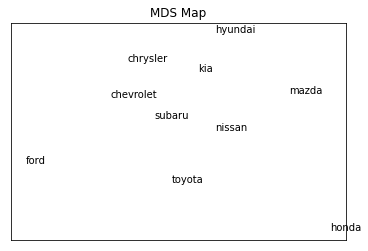

In [3]:
print("Top 10 Brands Frequency Table")
brand_sets = word_sets[word_sets['words'].isin(to_drop)]
print(brand_sets.sum(axis = 1).sort_values(ascending = False)[:10])

pd.set_option('display.expand_frame_repr', False)
print("\n\nLift Calculations Table")
print(pd.DataFrame(lift_square_matrix))

#Build MDS map from lift values
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import linear_kernel as cosine_distances
from sklearn.metrics.pairwise import manhattan_distances as manhattan_distances 
binary_variables = list(top_brand_sets.columns)
brand_matrix = top_brand_sets.to_numpy().transpose()
distance_matrix = manhattan_distances(brand_matrix)
mds_method = manifold.MDS(n_components=2, random_state = 9999, dissimilarity = 'precomputed')
mds_fit = mds_method.fit(distance_matrix)
mds_coordinates = mds_method.fit_transform(distance_matrix) 
plt.figure()
plt.scatter(mds_coordinates[:,0], mds_coordinates[:,1], facecolors = 'none', edgecolor = 'none')
plt.xticks([])
plt.yticks([])
plt.title("MDS Map")
labels = binary_variables 
for labels, x, y in zip(labels, mds_coordinates[:,0],mds_coordinates[:,1]):
    plt.annotate(labels, (x,y), xycoords = 'data')
plt.show()

**Task B: What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)?**

**Note:** our MDS map does not perfectly represent the lift values in the table above as the 10-dimensional matrix cannot be perfectly mapped onto the 2-dimensional graph. For the purposes of this analysis, we refer to the lift values in the table.

1. **Kia Insights** Kia is the most frequently associated brand with other brands. The association that would be the most insightful for a brand manager is the association between Kia and Chrysler. The overall lift score for this association is about 3.22. Although this association doesn’t have the highest lift score, a brand manager would find this insight quite actionable and valuable as we predict a brand manager would not expect Chrysler and Kia to be similar in the midsize sedan category. 

  Most likely, a Chrysler brand manager would predict that they are most like other domestic brands like Chevrolet or Ford. As for Kia’s brand manager, they most likely believe that Kia is most similar to other Asian import brands like Nissan, Toyota, or Honda. This insight means that Kia has an opportunity to market to people who own a midsized Chrysler sedan in the US which could improve their market share in the US. On the other hand, the brand manager for Chrysler may use this insight to market their brand to customers in Asian markets, a market that Kia is dominating in currently and one that Chrysler has very low market share in.  This similarity between Kia and Chrysler offers an insight into the balance between the US and Asian car markets, and the opportunity for Kia to expand their market share in the United States. 

2. **Hyundai Insights** Hyundai and Kia are the two most similar brands with a lift value of 3.79.  These two brands are most commonly compared in the Midsize Sedans forum. This means that Kia users are most likely to switch to Hyundai cars, and Hyundai users are most likely to switch to Kia cars. Hyundai and Kia are most interesting as they're both South Korea based automakers with a strong corporate connection. Hyundai Motor Companies currently owns 34% of Kia Motors. As these two brands have a high lift value, this suggests potential sales cannibalization between the two brands for Hyundai. The brand manager for Hyundai must dive deeper into the differentiation between these two brands and the different customer segments that they appeal to. 

  Most likely, Hyundai and Kia appeal to the same types of customers with their Midsize Sedans segment. Thus, it may be worthwhile for a Hyundai brand manager to dive deeper into the brand differences and made sure Hyundai and Kia's marketing is clearly targeted to different segments with distinct advertising strategy for each sedan. 


**Task C: What are 5 most frequently mentioned attributes of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.**





In [4]:
import pandas as pd 
import nltk
import numpy as np
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from collections import defaultdict
import re
from nltk.corpus import stopwords
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
import io
file = pd.read_csv(io.BytesIO(uploaded['comments.csv']))
file['comments'] = file['comments'].astype(str)

corpus = file['comments'].values

for i in range(len(corpus )):
    corpus [i] = corpus [i].lower()
    corpus [i] = re.sub(r'\W',' ',corpus [i]) #Replace all non-word character by ' '
    corpus [i] = re.sub(r'\s+',' ',corpus [i]) #Replace all multiple white space characters by ' '

import pandas as pd 
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

new_corpus = []
for sentence in corpus:
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    new_corpus.append(filtered_sentence)
#print(new_corpus)

filtered_corpus = np.asarray(new_corpus)

wordfreq = {}
for sentence in filtered_corpus:
#     tokens = nltk.word_tokenize(sentence)
    for token in sentence:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

#Get 500 most frequent words in descending order of count; manually figure out top attributes
import heapq
most_freq = heapq.nlargest(500, wordfreq, key=wordfreq.get)

list_attributes = ['mpg', 'price', 'interior', 'speed', 'engine']
#based on word frequency, top five attributes

list_brands = ['toyota', 'hyundai', 'honda', 'ford', 'mazda']

# Change brand x brand table to a brand x attribute table for the above lists

stops =set(stopwords.words("english"))
def identify_tokens(row):
    tokens = word_tokenize(row)
    # taken only words (not punctuation)
    #token_words = [w for w in tokens if w.isalpha() or w.isalnum()]
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

file['words'] = file['comments'].apply(identify_tokens)


def remove_stops(row):
    non_stop = [w for w in row if not w in stops]
    return (non_stop)

file['words'] = file['words'].apply(remove_stops)


def rejoin_words(row):
    joined_words = ( " ".join(row))
    return joined_words
file['processed'] = file['words'].apply(rejoin_words)


cv=CountVectorizer()
word_count_vector = cv.fit_transform(file['processed'])
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
word_count = pd.DataFrame(word_count_vector.T.todense(), index=cv.get_feature_names())

word_freq_matrix = word_count.T

df_idf.sort_values(by=['idf_weights'])

brandconverter = pd.read_csv('car models and brands.csv', header = None)
brandconverter = brandconverter.rename(columns={0: "brand",1:"model"})
view = word_count_vector.data

attribute = ['mpg', 'price', 'interior', 'speed', 'engine']
print("5 most frequently mentioned attributes of cars")
print(pd.Series(attribute))
brand_car = ['toyota', 'hyundai', 'honda', 'ford', 'mazda']
print("5 most frequently mentioned brands")
print(pd.Series(brand_car))
total = ['mpg', 'price', 'interior', 'speed', 'engine','toyota', 'hyundai', 'honda', 'ford', 'mazda']
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
word_sets = word_count.applymap(encode_units)
word_sets['words'] = word_sets.index.values
brand_sets = word_sets[word_sets['words'].isin(total)]
brand_sets = brand_sets.drop(columns = 'words')
brand_sets = brand_sets.T
#top_brand_sets = brand_sets[top_brands]
#brand_sets

#!pip install mlxtend

import mlxtend

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
frequent_itemsets = apriori(brand_sets, min_support=0.005, use_colnames=True )

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
lift_table = rules[['antecedents','consequents', 'lift']]
lift_table['length_antecedents'] = lift_table['antecedents'].apply(lambda x: len(x))
lift_table['length_consequents'] = lift_table['consequents'].apply(lambda x: len(x))

lift_table = lift_table[lift_table['length_antecedents'] == 1]
lift_table = lift_table[lift_table['length_consequents'] == 1]
lift_table = lift_table.drop(columns =['length_consequents','length_antecedents'] )

lift_table["antecedents"] = lift_table["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
lift_table["consequents"] = lift_table["consequents"].apply(lambda x: list(x)[0]).astype("unicode")

def ant_brand(x):
    if len(x) > 1:
        return False
    for v in x:
        return v in brand_car
    return False

def con_attr(x):
    if len(x) > 1:
        return False
    for v in x:
        return v in attribute
    return False

mask_ant = rules['antecedents'].map(ant_brand)
mask_con = rules['consequents'].map(con_attr)
rules = rules[mask_ant & mask_con]
rules

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
5 most frequently mentioned attributes of cars
0         mpg
1       price
2    interior
3       speed
4      engine
dtype: object
5 most frequently mentioned brands
0     toyota
1    hyundai
2      honda
3       ford
4      mazda
dtype: object


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ford),(engine),0.072277,0.076436,0.008911,0.123288,1.612960,0.003386,1.053441
2,(honda),(engine),0.116238,0.076436,0.016040,0.137990,1.805307,0.007155,1.071408
4,(hyundai),(engine),0.049901,0.076436,0.007723,0.154762,2.024735,0.003909,1.092668
8,(mazda),(engine),0.081980,0.076436,0.010693,0.130435,1.706465,0.004427,1.062099
16,(toyota),(engine),0.050495,0.076436,0.006535,0.129412,1.693081,0.002675,1.060851
23,(ford),(interior),0.072277,0.067129,0.007921,0.109589,1.632521,0.003069,1.047686
26,(ford),(mpg),0.072277,0.097228,0.007723,0.106849,1.098959,0.000695,1.010773
28,(ford),(price),0.072277,0.072673,0.007723,0.106849,1.470270,0.002470,1.038265
35,(honda),(interior),0.116238,0.067129,0.011881,0.102215,1.522667,0.004078,1.039081
38,(honda),(mpg),0.116238,0.097228,0.017624,0.151618,1.559415,0.006322,1.064111


The five most frequently mentioned attributes from the table above are: mpg, price, interior, speed, and engine. 

The brand most strongly associated with each characteristic (based on lift from the table above) is as follows: 

*   **MPG** - Honda
*   **Price** - Hyundai
*   **Interior** - Mazda
*   **Speed** - Hyundai
*   **Engine** - Hyundai


**Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive).**

Based on our analysis in Task C, we have a couple key insights for Hyundai, Honda, and Mazda based on their most typically associated attributes.

*    For **Hyundai**, it is most commonly mentioned with three of the top 5 attributes: Price, Speed, and Engine. This suggests a potential tradeoff between these three characteristics for Hyundai product managers. PMs should ensure Hyundai sedans stand out for 1 of these attributes. They should work together with the advertising managers to ensure 1 of the attributes is what Hyundai is best known for instead of the speed/engine tradeoff.

*    For **Honda**, their brand is most commonly associated with the mpg attribute. Hondo product managers should ensure that their sedans are fuel efficient as users associated Honda with a high MPG. Advertising managers should also consider fuel efficiency when appealing to environmentally conscious consumers.

*   For **Mazda**, the interior is the most frequently associated characteristic. Instead of their typical "Zoom-Zoom" slogan, Mazda advertising managers should emphasize the wonderful interiors of their vehicles. Product managers should ensure their sedans are well designed and have a comfortable interior ride. 

We also compiled some specific recommendations for product and brand managers.

1.	**Product Manager:** For product related suggestions, we recommend the attributes on which a brand is not doing well to the product manager and try to understand the reasons. The average lift value per attribute can be calculated. For example; the average lift value for ‘engine’ is (1.61+1.81+2.02+1.71+1.69)/5 ~ 1.77. We see that Ford has a substantially lesser lift value than the group average for engine. We must try fining the reasons behind it:

  a.	Does Ford engine have product related issues?

  b.	What does the customer feedback data received by the product management team reflect?

2.	**Brand Manager:** For suggestions related to branding, we want to market on attributes with high lift values and see whether our branding reflects the same. There can be two scenarios:
  
  a.	A brand might have a high lift value associated with an attribute. In this case, we want to ensure that we market this attribute as customers truly feel this attribute is very strong for our brand.

  b.	A brand might have a low lift value associated with an attribute. Looking at the branding strategy, if the brand markets this attribute but people do not feel the association


**Task E: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?**

List of Aspirational Words
     aspirational      words
0   aspirational        aim 
1   aspirational      aiming
2   aspirational     aspire 
3   aspirational    aspiring
4   aspirational       covet
5   aspirational      crave 
6   aspirational      desire
7   aspirational       dream
8   aspirational       goal 
9   aspirational       goals
10  aspirational        hope
11  aspirational      hoping
12  aspirational    longing 
13  aspirational        want
14  aspirational       wish 
15  aspirational     wishing
16  aspirational   yearning 
17  aspirational      dreams
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


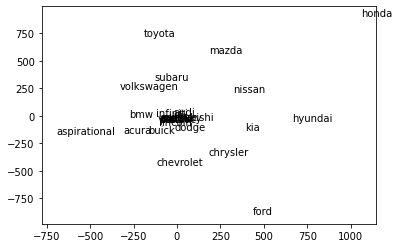

In [5]:
import pandas as pd 
import nltk
import numpy as np
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from collections import defaultdict
import re
from nltk.corpus import stopwords
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from google.colab import files
import io

file = pd.read_csv('comments.csv')
file['comments'] = file['comments'].astype(str)
file["comments"] = file["comments"].str.lower()

brandconverter = pd.read_csv("car models and brands.csv",header = None)
brandconverter.columns = ['brand','model']
s = brandconverter.set_index('model')['brand']
s.index = r'\b' + s.index + r'\b' # Takes care of word boundary condition
file['comments'] = file['comments'].replace(s, regex=True)

aspirationalwords = pd.read_csv(io.BytesIO(uploaded['aspirational words.csv']), header=None)
aspirationalwords.columns = ['aspirational', 'words']
print("List of Aspirational Words")
print(aspirationalwords)
t = aspirationalwords.set_index('words')['aspirational']
t.index = r'\b' + t.index + r'\b' # Takes care of word boundary condition
file['comments'] = file['comments'].replace(t, regex=True)

nltk.download('stopwords')
nltk.download('punkt')
stops =set(stopwords.words("english"))
def identify_tokens(row):
    tokens = nltk.word_tokenize(row)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

file['words'] = file['comments'].apply(identify_tokens)

def remove_stops(row):
    row
    non_stop = [w for w in row if not w in stops]
    return (non_stop)

file['words'] = file['words'].apply(remove_stops)

def rejoin_words(row):
    row
    joined_words = ( " ".join(row))
    return joined_words

file['processed'] = file['words'].apply(rejoin_words)
cv=CountVectorizer()
word_count_vector = cv.fit_transform(file['processed'])
word_count = pd.DataFrame(word_count_vector.T.todense(), index=cv.get_feature_names()) 
word_freq_matrix = word_count.T

counter = Counter(chain.from_iterable(map(str.split, file['processed'].tolist()))) 
view = word_count_vector.data
series = pd.Series(counter).sort_values(ascending=False)
term_freq = series.reset_index()
term_freq.columns = ['words','freq']
to_drop = list(brandconverter['brand'].unique())
to_drop.remove('problem')
to_drop.remove('seat')
to_drop.remove('car')
to_drop.remove('sedan')
to_drop.append('aspirational')

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
word_sets = word_count.applymap(encode_units)
word_sets['words'] = word_sets.index.values
brand_sets = word_sets[word_sets['words'].isin(to_drop)]

brand_sets = brand_sets.drop(columns = 'words')
brand_sets = brand_sets.T

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
frequent_itemsets = apriori(brand_sets, min_support=0.001, use_colnames=True )

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
lift_table = rules[['antecedents','consequents', 'lift']]
lift_table['length_antecedents'] = lift_table['antecedents'].apply(lambda x: len(x))
lift_table['length_consequents'] = lift_table['consequents'].apply(lambda x: len(x))

lift_table = lift_table[lift_table['length_antecedents'] == 1]
lift_table = lift_table[lift_table['length_consequents'] == 1]
lift_table = lift_table.drop(columns =['length_consequents','length_antecedents'] )

lift_table["antecedents"] = lift_table["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
lift_table["consequents"] = lift_table["consequents"].apply(lambda x: list(x)[0]).astype("unicode")

lift_square_matrix = lift_table.pivot(index='antecedents', columns='consequents', values='lift')
lift_square_matrix = lift_square_matrix.fillna(0)
m,n = lift_square_matrix.shape
lift_square_matrix[:] = np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,lift_square_matrix)
lift_square_matrix = lift_square_matrix.fillna('')
lift_square_matrix.columns.name = None
lift_square_matrix.index.name = None

from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import linear_kernel as cosine_distances
from sklearn.metrics.pairwise import manhattan_distances as manhattan_distances 
binary_variables = list(brand_sets.columns)
brand_matrix = brand_sets.to_numpy().transpose()
distance_matrix = manhattan_distances(brand_matrix)
mds_method = manifold.MDS(n_components=2, random_state = 9999, dissimilarity = 'precomputed')
mds_fit = mds_method.fit(distance_matrix)
mds_coordinates = mds_method.fit_transform(distance_matrix) 
plt.figure()
plt.scatter(mds_coordinates[:,0], mds_coordinates[:,1], facecolors = 'none', edgecolor = 'none')
labels = binary_variables 
for labels, x, y in zip(labels, mds_coordinates[:,0],mds_coordinates[:,1]):
    plt.annotate(labels, (x,y), xycoords = 'data')

plt.show()


**First, how we measured aspirational:**

In order to find the most “aspirational” car brand, “aspirational” needed to be defined in some way. For this, we created a list of “aspirational” words to identify within the forum. This list included words such as “wish,” “hope,” “desire,” and “dream” among others. The list is printed above. Next, we replaced each of the words in the list with “aspirational” so it would be easier to find these specific words in the comments in the forum. Then we identified any time “aspirational” was found with each of the car brands and finally calculated the lifts between the brands and “aspirational.” 

The lift table is shown below. This shows the lift between all the brands in the brand file and the "aspirational" measure we created from the list of aspirational words. 

In [6]:
pd.set_option('display.expand_frame_repr', False)
print("\n\nLift Calculations Table")
print(pd.DataFrame(lift_square_matrix)[:2])



Lift Calculations Table
             acura aspirational     audi      bmw    buick cadillac chevrolet chrysler    dodge     fiat     ford    honda hyundai infiniti      kia lincoln    mazda mitsubishi   nissan   subaru   toyota volkswagen volvo
acura                    1.4055  3.23148  3.61811  1.88228  8.05851   1.14943        0  1.73811        0        0  2.01417       0  6.61211  1.27407  4.5722  1.05685          0  1.01725  1.53874  1.22796    1.13102     0
aspirational                     2.15664  2.17298  1.64956        0   1.65753  1.46515  1.59778  2.37052  1.25698  1.33632  1.1332  2.67443  1.68341       0  1.60625          0  1.13149  1.56669   1.3433    1.15456     0


**Most aspirational brand is Inifiniti.**

After doing all of this, we found that Infiniti had the highest lift value of 2.67 with “aspirational” (followed by BMW and Audi). With this information, Infiniti can recognize that their brand is very much sought after. On the surface, it is instantly good to hear this as a brand, product, and advertising manager for Infiniti, but the key is to take advantage of this information. The managers should instantly be focused on marketing this “aspirational” brand in their advertisements. They should also continue to make their cars more appealing, now aware that people already aspire to own a car of that brand. 



**Advice/insights based on analysis for brand, product, and advertising managers.**

In general, brand managers should be aware of each brands their brand is most commonly mentioned with. We saw a surprising impact of this in the interaction between Chrysler and Kia. In general, understanding the attributes is also important as product managers must dive into their product design and resource allocation for features that they want to emphasize. Finally, advertising managers should use the brand and product strategy and customer sentiment to appeal to their target markets.